Połączenie ze sparkiem i wczytanie plików

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession\
        .builder\
        .master("local[2]")\
        .appName("Create-DataFrame")\
        .config("spark.memory.offHeap.enabled","true")\
        .config("spark.memory.offHeap.size","6g")\
        .getOrCreate()
spark.sparkContext

sc = spark.sparkContext

In [3]:
import pandas as pd
df = pd.read_excel('Online_Retail.xlsx')
df.to_csv('dane.csv', index=False)

In [4]:
df_spark = spark.read.option("header", "true").option("inferSchema", "true").csv("dane.csv")
df_spark.show(5, truncate=False)

+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |2010-12-01 08:26:00|2.55     |17850.0   |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |2010-12-01 08:26:00|3.39     |17850.0   |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |2010-12-01 08:26:00|2.75     |17850.0   |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |2010-12-01 08:26:00|3.39     |17850.0   |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |2010-12-01 08:26:00|3.39     |17850.0   |United Kingdom|
+---------+-----


Zrozumienie danych

In [5]:
df_spark.describe().show()

+-------+------------------+------------------+--------------------+------------------+-----------------+------------------+-----------+
|summary|         InvoiceNo|         StockCode|         Description|          Quantity|        UnitPrice|        CustomerID|    Country|
+-------+------------------+------------------+--------------------+------------------+-----------------+------------------+-----------+
|  count|            541909|            541909|              540455|            541909|           541909|            406829|     541909|
|   mean|  559965.752026781|27623.240210938104|             20713.0|  9.55224954743324| 4.61111362608298|15287.690570239585|       NULL|
| stddev|13428.417280803813|16799.737628427752|                NULL|218.08115785023477|96.75985306117967|1713.6003033215982|       NULL|
|    min|            536365|             10002| 4 PURPLE FLOCK D...|            -80995|        -11062.06|           12346.0|  Australia|
|    max|           C581569|             

In [9]:
df_spark.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)



Czyszczenie danych

In [12]:
from pyspark.sql import functions as F

df_spark.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df_spark.columns]).show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|       1454|       0|          0|        0|    135080|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



Usuwanie wierszy, które mają brakujące wartości we wszystkich kolumnach

In [15]:
df_spark = df_spark.dropna()

In [16]:
df_spark.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df_spark.columns]).show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|          0|       0|          0|        0|         0|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



In [18]:
df_spark = df_spark.withColumn('amount', F.col('Quantity') * F.col('UnitPrice'))

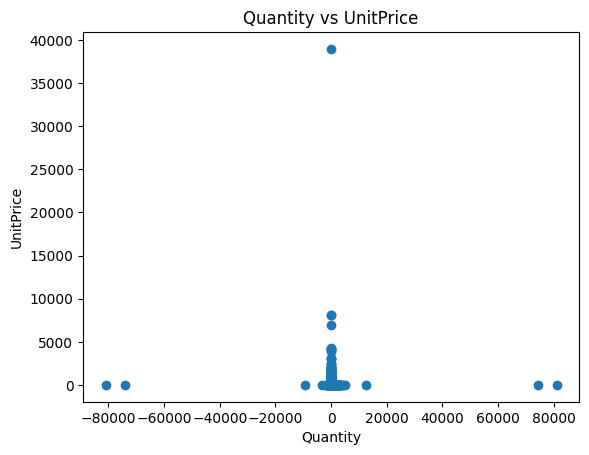

In [22]:
import matplotlib.pyplot as plt

quantity = df_spark.select('Quantity').toPandas()['Quantity']
unit_price = df_spark.select('UnitPrice').toPandas()['UnitPrice']

plt.scatter(quantity, unit_price)
plt.xlabel('Quantity')
plt.ylabel('UnitPrice')
plt.title('Quantity vs UnitPrice')
plt.show()

In [23]:
df_spark = df_spark.filter((F.col('Quantity') > 0) & (F.col('Quantity') < 6000))

Usuwanie elementu odstającego

In [24]:
def remove_out(df_clean, num_cols, lbv=0.25, hbv=0.75):
    quantiles = df_clean.approxQuantile(num_cols, [lbv, hbv], 0.01)

    lower_bounds = {col: quantiles[i][0] for i, col in enumerate(num_cols)}
    upper_bounds = {col: quantiles[i][1] for i, col in enumerate(num_cols)}

    cleaned_df = df_clean
    for col in num_cols:
        IQR = upper_bounds[col] - lower_bounds[col]
        lb = lower_bounds[col] - 1.5 * IQR
        hb = upper_bounds[col] + 1.5 * IQR
        cleaned_df = cleaned_df.filter((F.col(col) >= lb) & (F.col(col) <= hb))

    return cleaned_df

In [25]:
num_rows = df_spark.count()
num_columns = len(df_spark.columns)
print(f"Rows: {num_rows}, Columns: {num_columns}")

Rows: 397921, Columns: 9


In [27]:
from pyspark.sql import functions as F

df_spark = remove_out(df_spark, ['Quantity', 'UnitPrice', 'amount'], lbv=0.05, hbv=0.90)

num_rows = df_spark.count()
num_columns = len(df_spark.columns)
print(f"Rows: {num_rows}, Columns: {num_columns}")

Rows: 376634, Columns: 9


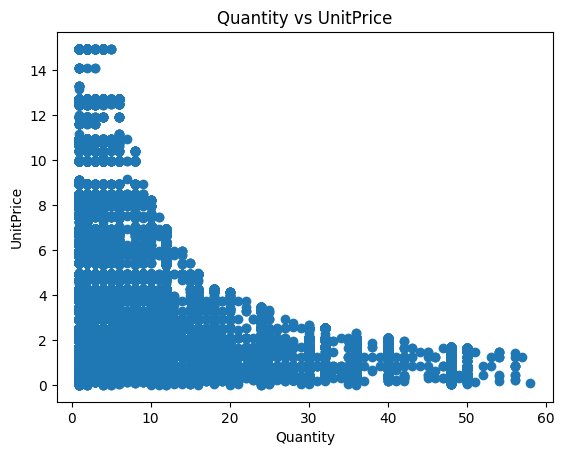

In [28]:
import matplotlib.pyplot as plt

quantity = df_spark.select('Quantity').toPandas()['Quantity']
unit_price = df_spark.select('UnitPrice').toPandas()['UnitPrice']

plt.scatter(quantity, unit_price)
plt.xlabel('Quantity')
plt.ylabel('UnitPrice')
plt.title('Quantity vs UnitPrice')
plt.show()

Przygotowanie danych do modelowania

*   R (ostatni): Liczba dni od ostatniego zakupu
*   F (Częstotliwość): Liczba tras
*   M (pieniężna): Całkowita kwota transakcji (wniesiony dochód)

In [29]:
df_spark = df_spark.withColumn('InvoiceDate', F.to_timestamp('InvoiceDate', 'dd-MM-yyyy HH:mm'))

In [30]:
df_spark.show()

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|            amount|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|15.299999999999999|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|             20.34|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|              22.0|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|             20.34|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|    

The Reference Forward Model (RFM)

*   RFM to model transferu radiacyjnego typu „linia po linii” ogólnego przeznaczenia.
*   RFM tworzy widma promieniowania podczerwonego i transmitancji.
*   W artykule opisano podstawowe algorytmy stosowane przez RFM.
*   RFM został zaprojektowany tak, aby był solidny, przenośny i elastyczny.

In [31]:
max_date = df_spark.agg(F.max('InvoiceDate')).collect()[0][0]
print(max_date)
retail_df = df_spark.withColumn('diff', F.datediff(F.lit(max_date), F.col('InvoiceDate')))

2011-12-09 12:50:00


In [33]:
frequency = df_spark.groupBy('CustomerID').agg(F.countDistinct('InvoiceNo').alias('Frequency'))
df_spark = df_spark.join(frequency, on='CustomerID', how='left')
df_spark.show(5)

+----------+---------+---------+--------------------+--------+-------------------+---------+--------------+------------------+---------+
|CustomerID|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|       Country|            amount|Frequency|
+----------+---------+---------+--------------------+--------+-------------------+---------+--------------+------------------+---------+
|   17850.0|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|United Kingdom|15.299999999999999|       34|
|   17850.0|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|United Kingdom|             20.34|       34|
|   17850.0|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|United Kingdom|              22.0|       34|
|   17850.0|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|United Kingdom|             20.34|       34|
|   17850.0|   536365|   84029E|RED WOOLL

In [35]:
max_date = df_spark.agg(F.max('InvoiceDate')).collect()[0][0]

df_spark = df_spark.withColumn('diff', F.datediff(F.lit(max_date), F.col('InvoiceDate')))

rfm_df = df_spark.groupBy('CustomerID').agg(
    F.min('diff').alias('recency'),           # Najnowsza różnica (min diff)
    F.sum('Frequency').alias('frequency'),    # Suma częstotliwości
    F.sum('amount').alias('amount')           # Suma wartości zakupów
)

rfm_df.show(5)

+----------+-------+---------+------------------+
|CustomerID|recency|frequency|            amount|
+----------+-------+---------+------------------+
|   16916.0|     23|      286| 576.2599999999999|
|   17884.0|      3|      460| 707.8499999999998|
|   13094.0|    156|       16|248.27999999999997|
|   16596.0|     15|       24|            250.15|
|   18114.0|    290|       26|178.20000000000002|
+----------+-------+---------+------------------+
only showing top 5 rows



In [37]:
max_date = df_spark.agg(F.max('InvoiceDate')).collect()[0][0]

df_spark = df_spark.withColumn('diff', F.datediff(F.lit(max_date), F.col('InvoiceDate')))

rfm_df = df_spark.groupBy('CustomerID').agg(
    F.min('diff').alias('recency'),           # Najnowsza różnica (min diff)
    F.sum('Frequency').alias('frequency'),    # Suma częstotliwości
    F.sum('amount').alias('amount')           # Suma wartości zakupów
)

rfm_df = rfm_df.withColumn('recency', F.col('recency').cast('int'))

rfm_df.show(5)

+----------+-------+---------+------------------+
|CustomerID|recency|frequency|            amount|
+----------+-------+---------+------------------+
|   16916.0|     23|      286| 576.2599999999999|
|   17884.0|      3|      460| 707.8499999999998|
|   13094.0|    156|       16|248.27999999999997|
|   16596.0|     15|       24|            250.15|
|   18114.0|    290|       26|178.20000000000002|
+----------+-------+---------+------------------+
only showing top 5 rows



Usuwanie elementow odstajacych

In [38]:
def remove_out(df, num_cols, lbv=0.05, hbv=0.95):
    percentiles = df.approxQuantile(num_cols, [lbv, hbv], 0.01)

    for col, (low, high) in zip(num_cols, percentiles):
        df = df.filter((F.col(col) >= low) & (F.col(col) <= high))

    return df

rfm_df = remove_out(rfm_df, ['recency', 'frequency', 'amount'], lbv=0.05, hbv=0.95)

rfm_df_count = rfm_df.count()  # Liczba wierszy w DataFrame
print(f"Liczba wierszy po usunięciu wartości odstających: {rfm_df_count}")

Liczba wierszy po usunięciu wartości odstających: 3394


Skalowanie danych

In [40]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.sql import functions as F

assembler = VectorAssembler(inputCols=['amount', 'frequency', 'recency'], outputCol='features')
rfm_df_vectorized = assembler.transform(rfm_df)

scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
scaler_model = scaler.fit(rfm_df_vectorized)
rfm_df_scaled = scaler_model.transform(rfm_df_vectorized)

rfm_df_scaled.show(5)

scaled_count = rfm_df_scaled.count()
print(f"Liczba wierszy w skalowanym DataFrame: {scaled_count}")

+----------+-------+---------+------------------+--------------------+--------------------+
|CustomerID|recency|frequency|            amount|            features|     scaled_features|
+----------+-------+---------+------------------+--------------------+--------------------+
|   16916.0|     23|      286| 576.2599999999999|[576.259999999999...|[-0.3479439003853...|
|   17884.0|      3|      460| 707.8499999999998|[707.849999999999...|[-0.1804826302877...|
|   13094.0|    156|       16|248.27999999999997|[248.279999999999...|[-0.7653308398687...|
|   16596.0|     15|       24|            250.15|  [250.15,24.0,15.0]|[-0.7629510801979...|
|   18114.0|    290|       26|178.20000000000002|[178.200000000000...|[-0.8545145605803...|
+----------+-------+---------+------------------+--------------------+--------------------+
only showing top 5 rows

Liczba wierszy w skalowanym DataFrame: 3394


In [41]:
rfm_df_scaled_pandas = rfm_df_scaled.select('scaled_features').toPandas()

rfm_df_scaled_pandas[['amount', 'frequency', 'recency']] = pd.DataFrame(
    rfm_df_scaled_pandas['scaled_features'].to_list(), index=rfm_df_scaled_pandas.index
)

rfm_df_scaled_pandas.head()

,scaled_features,amount,frequency,recency
0,"[-0.34794390038532924, 0.031362857140819954, -...",-0.347944,0.031363,-0.727927
1,"[-0.18048263028770478, 0.432809060007345, -0.9...",-0.180483,0.432809,-0.978029
2,"[-0.7653308398687162, -0.5915709059279258, 0.9...",-0.765331,-0.591571,0.935252
3,"[-0.762951080197901, -0.5731136092444074, -0.8...",-0.762951,-0.573114,-0.827968
4,"[-0.8545145605803319, -0.5684992850735278, 2.6...",-0.854515,-0.568499,2.610936


Modelowanie

In [43]:
from sklearn.cluster import KMeans

X = rfm_df_scaled_pandas[['amount', 'frequency', 'recency']].values

kmeans = KMeans(n_clusters=4, max_iter=80, random_state=42)  # random_state gwarantuje powtarzalność wyników

kmeans.fit(X)

rfm_df_scaled_pandas['cluster'] = kmeans.labels_

rfm_df_scaled_pandas.head()

,scaled_features,amount,frequency,recency,cluster
0,"[-0.34794390038532924, 0.031362857140819954, -...",-0.347944,0.031363,-0.727927,3
1,"[-0.18048263028770478, 0.432809060007345, -0.9...",-0.180483,0.432809,-0.978029,3
2,"[-0.7653308398687162, -0.5915709059279258, 0.9...",-0.765331,-0.591571,0.935252,2
3,"[-0.762951080197901, -0.5731136092444074, -0.8...",-0.762951,-0.573114,-0.827968,3
4,"[-0.8545145605803319, -0.5684992850735278, 2.6...",-0.854515,-0.568499,2.610936,2


Metoda łokcia

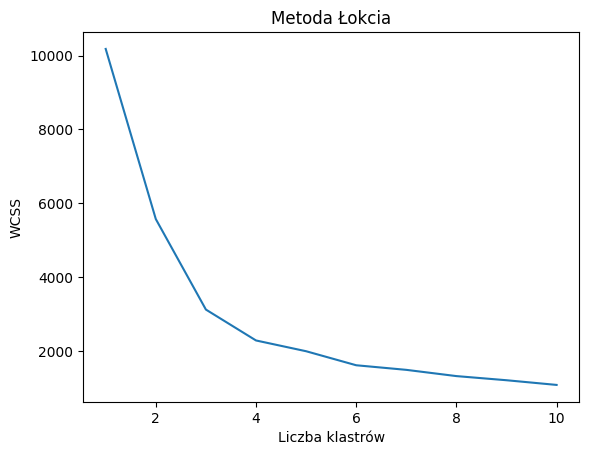

In [44]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Metoda Łokcia')
plt.xlabel('Liczba klastrów')
plt.ylabel('WCSS')
plt.show()

Silhouette Score

In [45]:
from sklearn.metrics import silhouette_score

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    print(f"Liczba klastrów: {i}, Silhouette Score: {score}")

Liczba klastrów: 2, Silhouette Score: 0.5160924508623222
Liczba klastrów: 3, Silhouette Score: 0.5070157762119291
Liczba klastrów: 4, Silhouette Score: 0.47704127132460356
Liczba klastrów: 5, Silhouette Score: 0.3996738707872295
Liczba klastrów: 6, Silhouette Score: 0.4033203176189568
Liczba klastrów: 7, Silhouette Score: 0.40601180767450235
Liczba klastrów: 8, Silhouette Score: 0.370711770397301
Liczba klastrów: 9, Silhouette Score: 0.34597238256384477
Liczba klastrów: 10, Silhouette Score: 0.3483617591274533


In [46]:
print(kmeans.labels_)

[6 6 8 ... 1 3 1]


Znalezienie optymalnej liczby klastrów

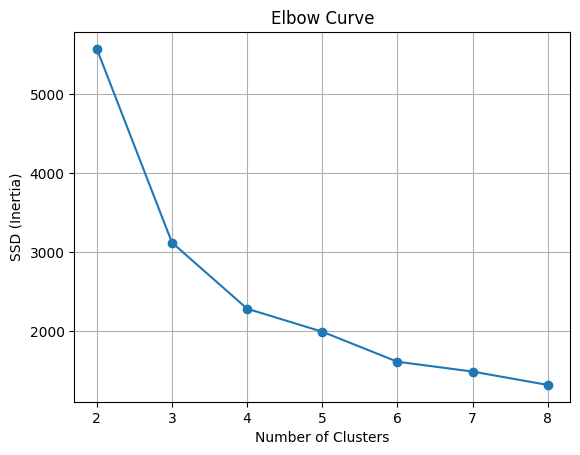

In [52]:
# Konwertowanie z PySpark do pandas DataFrame
rfm_df_scaled_pd = rfm_df_scaled.toPandas()

# Rozpakowywanie DenseVector do numerycznych wartości
rfm_df_scaled_np = np.array([row.toArray() for row in rfm_df_scaled_pd['scaled_features']])

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=80, random_state=42)  # Dodajemy random_state dla powtarzalności
    kmeans.fit(rfm_df_scaled_np)  # Teraz przekazujemy numeryczne dane

    ssd.append(kmeans.inertia_)

# Rysowanie wykresu SSD
plt.plot(range_n_clusters, ssd, marker='o')
plt.title('Elbow Curve')
plt.xlabel('Number of Clusters')
plt.ylabel('SSD (Inertia)')
plt.grid(True)
plt.show()

Analiza sylwetki

p to średnia odległość do punktów w najbliższym klastrze, do którego dany punkt danych nie należy.

q to średnia odległość wewnątrz klastra do wszystkich punktów w jego własnym klastrze.

*   Wartość wskaźnika sylwetki mieści się w przedziale od -1 do 1.
*   Wynik bliższy 1 oznacza, że punkt danych jest bardzo podobny do innych punktów w tym samym klastrze.
*   Wynik bliższy -1 oznacza, że punkt danych jest mało podobny do punktów w swoim klastrze.

For n_clusters=2, the silhouette score is 0.7060503495639332
For n_clusters=3, the silhouette score is 0.6900297239918735
For n_clusters=4, the silhouette score is 0.6581530384857998
For n_clusters=5, the silhouette score is 0.6085232700150461
For n_clusters=6, the silhouette score is 0.6022018418338692
For n_clusters=7, the silhouette score is 0.529634679445885
For n_clusters=8, the silhouette score is 0.47330328737515326


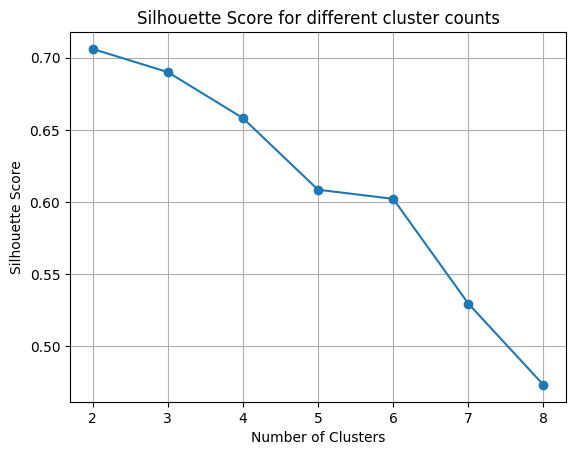

In [61]:
# Usuwamy istniejącą kolumnę 'features', jeśli już istnieje
rfm_df = rfm_df.drop('features')

# Przekształcenie cech w jeden wektor przy użyciu VectorAssembler
assembler = VectorAssembler(inputCols=['amount', 'frequency', 'recency'], outputCol='features')
rfm_df = assembler.transform(rfm_df)

# Zastosowanie StandardScaler do skalowania cech
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=False)
scaler_model = scaler.fit(rfm_df)
rfm_df_scaled = scaler_model.transform(rfm_df)

# Silhouette analysis dla różnych liczby klastrów
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_scores = []

for num_clusters in range_n_clusters:
    # Inicjalizacja KMeans z wyższą liczbą iteracji i z inną inicjalizacją centroidów
    kmeans = KMeans().setK(num_clusters).setSeed(42).setFeaturesCol('scaled_features').setPredictionCol('prediction').setMaxIter(100)  # maxIter=100

    # Trening modelu
    kmeans_model = kmeans.fit(rfm_df_scaled)

    # Predykcja (przypisanie etykiet klastrów do danych)
    predictions = kmeans_model.transform(rfm_df_scaled)

    # Obliczanie Silhouette Score
    evaluator = ClusteringEvaluator(featuresCol='scaled_features', predictionCol='prediction', metricName='silhouette')
    silhouette_avg = evaluator.evaluate(predictions)

    print(f"For n_clusters={num_clusters}, the silhouette score is {silhouette_avg}")

    silhouette_scores.append(silhouette_avg)

plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Score for different cluster counts')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 2059|
|         2|  543|
|         0|  792|
+----------+-----+

Centroids of clusters:
Cluster 0: [0.51778713 0.14338969 2.6028416 ]
Cluster 1: [0.81626068 0.33908886 0.54953733]
Cluster 2: [2.93654459 2.46007065 0.4320898 ]


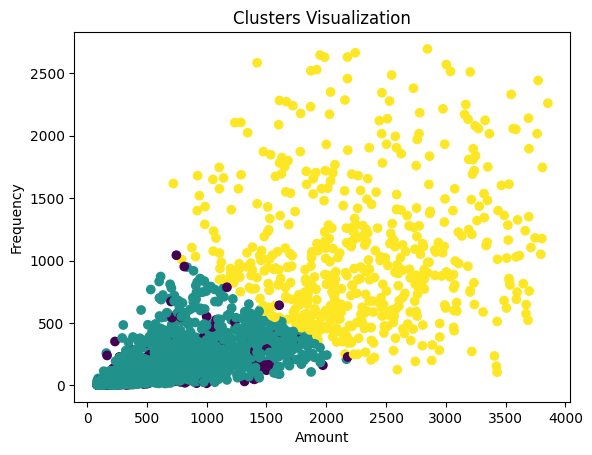

In [62]:
kmeans = KMeans().setK(3).setSeed(42).setFeaturesCol('scaled_features').setPredictionCol('prediction')
kmeans_model = kmeans.fit(rfm_df_scaled)

predictions = kmeans_model.transform(rfm_df_scaled)

predictions.groupBy("prediction").count().show()

centroids = kmeans_model.clusterCenters()
print("Centroids of clusters:")
for i, center in enumerate(centroids):
    print(f"Cluster {i}: {center}")

data_for_plot = predictions.select('amount', 'frequency', 'prediction').toPandas()

plt.scatter(data_for_plot['amount'], data_for_plot['frequency'], c=data_for_plot['prediction'], cmap='viridis')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Clusters Visualization')
plt.show()

In [63]:
# Przewidywanie klastra dla danych
predictions = kmeans_model.transform(rfm_df_scaled)
# Wyświetlenie etykiet klastra
labels = predictions.select('prediction').collect()
# Konwertowanie wyników na listę
labels_list = [row['prediction'] for row in labels]

print(labels_list)

[1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 0, 0, 2, 2, 0, 0, 1, 1, 2, 0, 1, 1, 1, 0, 1, 2, 0, 2, 2, 1, 0, 0, 0, 0, 2, 2, 0, 2, 1, 0, 1, 0, 0, 1, 2, 1, 0, 1, 2, 0, 1, 0, 1, 2, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 2, 1, 1, 0, 1, 0, 1, 2, 1, 0, 1, 0, 1, 2, 1, 0, 2, 0, 2, 1, 0, 0, 2, 2, 2, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 2, 2, 0, 1, 2, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 2, 2, 2, 1, 0, 2, 0, 2, 1, 2, 0, 0, 0, 2, 0, 0, 1, 1, 0, 2, 2, 0, 1, 2, 1, 0, 1, 1, 1, 1, 1, 0, 0, 2, 1, 1, 1, 2, 2, 1, 2, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 2, 1, 0, 2, 1, 1, 2, 1, 0, 2, 2, 2, 0, 1, 0, 1, 1, 1, 0, 2, 0, 1, 1, 0, 2, 2, 1, 0, 1, 1, 1, 0, 1, 2, 2, 2, 1, 2, 2, 2, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 2, 1, 1, 0, 0, 2, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 2, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 1, 0, 0, 0, 1, 1, 1, 2, 2, 0, 1, 2, 0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 2, 

In [64]:
predictions = kmeans_model.transform(rfm_df_scaled)  # Klastry w kolumnie 'prediction'

rfm_df_with_clusters = predictions.select('amount', 'frequency', 'recency', 'prediction')

rfm_df_with_clusters = rfm_df_with_clusters.withColumnRenamed('prediction', 'cluster_id')

rfm_df_with_clusters.show(5)

+------------------+---------+-------+----------+
|            amount|frequency|recency|cluster_id|
+------------------+---------+-------+----------+
| 576.2599999999999|      286|     23|         1|
| 707.8499999999998|      460|      3|         1|
|248.27999999999997|       16|    156|         0|
|            250.15|       24|     15|         1|
|178.20000000000002|       26|    290|         0|
+------------------+---------+-------+----------+
only showing top 5 rows



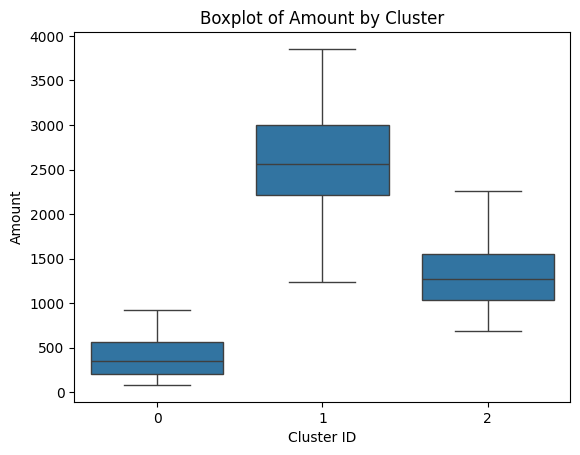

In [72]:
if 'features' in rfm_df.columns:
    rfm_df = rfm_df.drop('features')

assembler = VectorAssembler(inputCols=['amount', 'frequency', 'recency'], outputCol='features')
rfm_df = assembler.transform(rfm_df)

kmeans = KMeans(k=3, seed=42, featuresCol='features', predictionCol='prediction')
model = kmeans.fit(rfm_df)

rfm_df_with_clusters = model.transform(rfm_df)

rfm_df_pd = rfm_df_with_clusters.select('amount', 'frequency', 'recency', 'prediction').toPandas()

sns.boxplot(x='prediction', y='amount', data=rfm_df_pd)
plt.title('Boxplot of Amount by Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Amount')
plt.show()

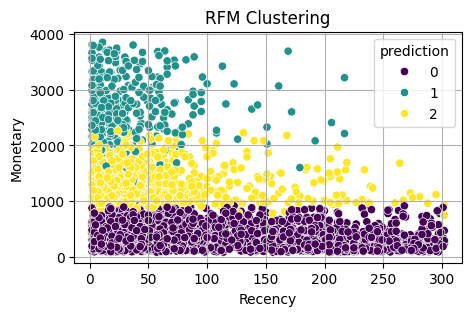

In [77]:
if 'features' in rfm_df.columns:
    rfm_df = rfm_df.drop('features')

assembler = VectorAssembler(inputCols=['amount', 'frequency', 'recency'], outputCol='features')
rfm_df = assembler.transform(rfm_df)

kmeans = KMeans(k=3, seed=42, featuresCol='features', predictionCol='prediction')
model = kmeans.fit(rfm_df)

rfm_df = model.transform(rfm_df)

rfm_df_pd = rfm_df.select("recency", "amount", "prediction").toPandas()

plt.figure(figsize=(5, 3))
sns.scatterplot(data=rfm_df_pd, x='recency', y='amount', hue='prediction', palette='viridis')
plt.title('RFM Clustering')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.grid(True)
plt.show()